# Marine Heat Wave Analysis on OISST

This notebook loads the OISST data and then conducts Marine Heat Wave (MHW) detection on a grid subset. It uses Eric Oliver's marineHeatWaves package which implements the Marine Heat Wave (MHW) definition of Hobday et al. (2016)

The goal for writing this code is to get the MHW package working and compute the total number of MHW events. There are two methods used:

(1) Sequential Loop <br>
(2) Parallelizing

After the MHW package is run on a very small subset, a time series plot at a specific grid point is generated highlighting where marine heat waves occur. A marine heat wave is defined where SST is above the 90th percentile threshold for at least 5 days.

*Note: Used NPL 2025a kernel*

## Import Libraries

In [1]:
# Import libraries
import dask.array as da
from dask import delayed, compute
from dask.diagnostics import ProgressBar
from dask.distributed import LocalCluster, Client, progress
import datetime
import glob
from joblib import Parallel, delayed
import marineHeatWaves as mhw
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import warnings
import xarray as xr
warnings.filterwarnings('ignore')
xr.set_options(display_expand_data=False);

## Load the Data

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:40661' processes=6 threads=36, memory=384.00 GiB>

In [3]:
# Read in data

# Get list of .nc files, excluding "preliminary" ones
file_list = glob.glob('/glade/campaign/univ/ucub0175/OISST/*.nc')
file_list = [file_name for file_name in file_list if "preliminary" not in file_name]

# files in list are not in order by date
print(f"Path of first file in file_list: {file_list[0]}")

file_list_sorted = sorted(file_list)
print(f"Path of first file in sorted file_list: {file_list_sorted[0]}")

print(f"Found {len(file_list)} files")
# 15979 files without preliminary
# 15993 total files

Path of first file in file_list: /glade/campaign/univ/ucub0175/OISST/oisst-avhrr-v02r01.19911020.nc
Path of first file in sorted file_list: /glade/campaign/univ/ucub0175/OISST/oisst-avhrr-v02r01.19810901.nc
Found 15979 files


In [4]:
%%time
# Create SST xarray.Dataset (dask when specify chunks)
combined_sst = xr.open_mfdataset(
    file_list_sorted,
    concat_dim='time',
    combine='nested',
    parallel=True,           # use dask to load in parallel
    preprocess=lambda ds: ds[['sst']],  # only keep SST variable
    chunks={'lat': 120, 'lon': 240},  # break up by year
    engine='netcdf4'
)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 240. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  return func(*args, **kwargs)
/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/dask/utils.py:77: UserWarning: The 

CPU times: user 52.5 s, sys: 3.08 s, total: 55.6 s
Wall time: 1min 16s


In [5]:
combined_sst

<xarray.Dataset> Size: 66GB
Dimensions:  (time: 15979, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01T1...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    sst      (time, zlev, lat, lon) float32 66GB dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.19810901.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [6]:
# Check time range
print(combined_sst['time'].values[0], combined_sst['time'].values[-1])
# 1981-09-01 to 2025-06-01

1981-09-01T12:00:00.000000000 2025-06-01T12:00:00.000000000


In [7]:
sst = combined_sst['sst']
sst

<xarray.DataArray 'sst' (time: 15979, zlev: 1, lat: 720, lon: 1440)> Size: 66GB
dask.array<chunksize=(1, 1, 120, 240), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 128kB 1981-09-01T12:00:00 ... 2025-06-01T1...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [8]:
print(combined_sst.time.dtype)  # datetime64[ns]

datetime64[ns]


## MHW Detection

In [9]:
print(dir(mhw))  # detect() and stats() exist

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'blockAverage', 'date', 'detect', 'linalg', 'meanTrend', 'ndimage', 'nonans', 'np', 'pad', 'rank', 'runavg', 'sp', 'stats']


### Define Small Grid Subset

In [10]:
# Specify very small SST subset
sst_subset = sst.sel(
    lat=slice(0, 5),
    lon=slice(180, 185),                    # narrow longitude slice
    time=slice('1983-01-01', '1993-12-31')  # 10-year time window
)

In [11]:
sst_subset

<xarray.DataArray 'sst' (time: 4018, zlev: 1, lat: 20, lon: 20)> Size: 6MB
dask.array<chunksize=(1, 1, 20, 20), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 80B 0.125 0.375 0.625 0.875 ... 4.375 4.625 4.875
  * lon      (lon) float32 80B 180.1 180.4 180.6 180.9 ... 184.4 184.6 184.9
  * time     (time) datetime64[ns] 32kB 1983-01-01T12:00:00 ... 1993-12-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [12]:
sst_subset.load()

<xarray.DataArray 'sst' (time: 4018, zlev: 1, lat: 20, lon: 20)> Size: 6MB
28.31 28.29 28.3 28.41 28.49 28.43 28.27 ... 28.96 28.8 28.78 28.81 28.81 28.67
Coordinates:
  * lat      (lat) float32 80B 0.125 0.375 0.625 0.875 ... 4.375 4.625 4.875
  * lon      (lon) float32 80B 180.1 180.4 180.6 180.9 ... 184.4 184.6 184.9
  * time     (time) datetime64[ns] 32kB 1983-01-01T12:00:00 ... 1993-12-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

### Define Necessary Variables

In [13]:
# Define necessary variables that contain SST values
lat_vals = sst_subset['lat'].values
lon_vals = sst_subset['lon'].values
time_vals = sst_subset['time'].values  # datetime64

# np datetime64 --> list of ordinal day integers
time_ord = np.array([pd.Timestamp(t).toordinal() for t in time_vals])

In [14]:
# Troubleshooting
# print(sst_subset['lon'].values)
# print(sst_subset['lat'].values)
# print(len(sst_subset['lon'].values)) # 20
# print(len(sst_subset['lat'].values)) # 20

### Method 1: Sequential Loop (Slower)

In [15]:
%%time

# Wall time: 23.2 sec

# Empty np array to store results
mhws = np.empty((len(lat_vals), len(lon_vals)), dtype=object)

# Loop over lat/lon
for i, lat in enumerate(lat_vals):
    for j, lon in enumerate(lon_vals):
        # Get time series at this (i, j) grid point
        sst_ts = sst_subset.isel(lat=i, lon=j).values.squeeze()  # need 1D array over time at grid pt
    
        # Skip if all values are NaN
        if np.isnan(sst_ts).all():
            mhws[i, j] = None
            continue

        # Detect MHWs
        # mhw_result = mhw.detect(time_ord, sst_ts)
        mhw_events, _ = mhw.detect(time_ord, sst_ts)

        # Store result
        mhws[i, j] = mhw_events

CPU times: user 23.2 s, sys: 694 ms, total: 23.9 s
Wall time: 23.2 s


In [16]:
# Troubleshooting
# print(sst_ts.shape)       # Should be (time,)
# print(time_ord.shape)     # Should be (time,)
# print(sst_ts.ndim)        # Should be 1
# print(time_ord.ndim)      # Should be 1
# print(lat_vals[:10])
# print(lon_vals[:10])
# print(time_vals[:10])

### Total Number of MHW Events (on Grid Subset)

In [17]:
total_events = sum(
    mhws[i, j]['n_events']
    for i in range(mhws.shape[0])
    for j in range(mhws.shape[1])
    if mhws[i, j] is not None
)
print("Total MHW events across 20x20 grid:", total_events)  # 8902

Total MHW events across 20x20 grid: 8902


### Method 2: Parallelizing

In [18]:
sst_subset

<xarray.DataArray 'sst' (time: 4018, zlev: 1, lat: 20, lon: 20)> Size: 6MB
28.31 28.29 28.3 28.41 28.49 28.43 28.27 ... 28.96 28.8 28.78 28.81 28.81 28.67
Coordinates:
  * lat      (lat) float32 80B 0.125 0.375 0.625 0.875 ... 4.375 4.625 4.875
  * lon      (lon) float32 80B 180.1 180.4 180.6 180.9 ... 184.4 184.6 184.9
  * time     (time) datetime64[ns] 32kB 1983-01-01T12:00:00 ... 1993-12-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

In [19]:
def detect_mhw_at_point(i, j, sst_data, time_ord):
    # print(f"Detecting MHW at grid ({i},{j})")
    # print(type(sst_data))
    # print(sst_data)
    # Get 1D time series
    sst_ts = sst_data.isel(lat=i, lon=j).values.squeeze().copy() # value error (.values = read only)

    if np.isnan(sst_ts).all():
        return (i, j, None)  # return coordinates and None

    # Run MHW detection
    mhw_events, _ = mhw.detect(time_ord, sst_ts)

    return (i, j, mhw_events)

In [20]:
%%time

# Wall time: 3.43 s

# Run in parallel (n_jobs=-1 uses all cores)
# use Joblib for parallelizing
results = Parallel(n_jobs=-1)(
    delayed(detect_mhw_at_point)(i, j, sst_subset, time_ord)
    for i in range(len(lat_vals))
    for j in range(len(lon_vals))
)
# output is list of tuples

CPU times: user 654 ms, sys: 1.45 s, total: 2.1 s
Wall time: 3.43 s


In [21]:
# Store results in 2d np array
mhws = np.empty((len(lat_vals), len(lon_vals)), dtype=object)

for i, j, mhw_events in results:
    mhws[i, j] = mhw_events

### Total Number of MHW Events (on Grid Subset)

In [22]:
total_events = sum(
    mhws[i, j]['n_events']
    for i in range(mhws.shape[0])
    for j in range(mhws.shape[1])
    if mhws[i, j] is not None
)
print("Total MHW events across 20x20 grid:", total_events) # 8902

# Example
i, j = 3, 15
result_at_point = mhws[i, j]

print(f"Number of MHW events at (i={i}, j={j}):", result_at_point['n_events']) # 24

Total MHW events across 20x20 grid: 8902
Number of MHW events at (i=3, j=15): 24


### Plot Number of MHW Events at Each Point (on Grid Subset)

In [23]:
n_events_map = np.full(mhws.shape, np.nan)

for i in range(mhws.shape[0]):
    for j in range(mhws.shape[1]):
        if mhws[i, j] is not None:
            n_events_map[i, j] = mhws[i, j]['n_events']

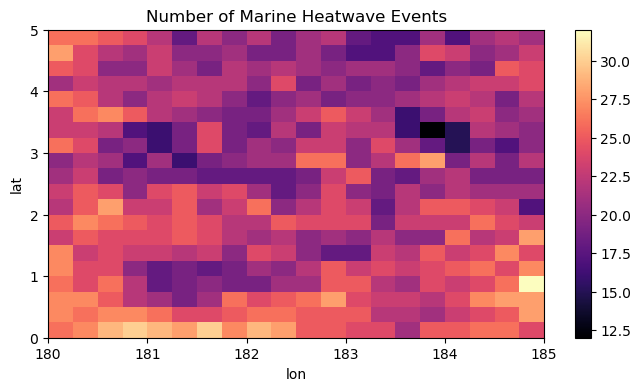

In [24]:
n_events_da = xr.DataArray(
    n_events_map,
    coords={'lat': lat_vals, 'lon': lon_vals},
    dims=['lat', 'lon']
)

n_events_da.plot(cmap='magma', figsize=(8, 4))
plt.title("Number of Marine Heatwave Events")
plt.show()

### Plot Time Series at a Grid Point With Indices (i, j)

In [25]:
i, j = 10, 10  # spatial
lat_val = sst_subset['lat'].isel(lat=i).values
lon_val = sst_subset['lon'].isel(lon=i).values
print(f"Testing point at lat={lat_val}, lon={lon_val}")

Testing point at lat=2.625, lon=182.625


In [26]:
# sst_ts = sst_anom_subset.isel(zlev=0, lat=i, lon=j).values.squeeze()
sst_ts = sst_subset.isel(zlev=0, lat=i, lon=j).values.squeeze()
# time_vals = sst_anom_subset['time'].values
time_vals = sst_subset['time'].values
time_ord = np.array([pd.Timestamp(t).toordinal() for t in time_vals])

mhw_events, mhw_thresholds = mhw.detect(time_ord, sst_ts)

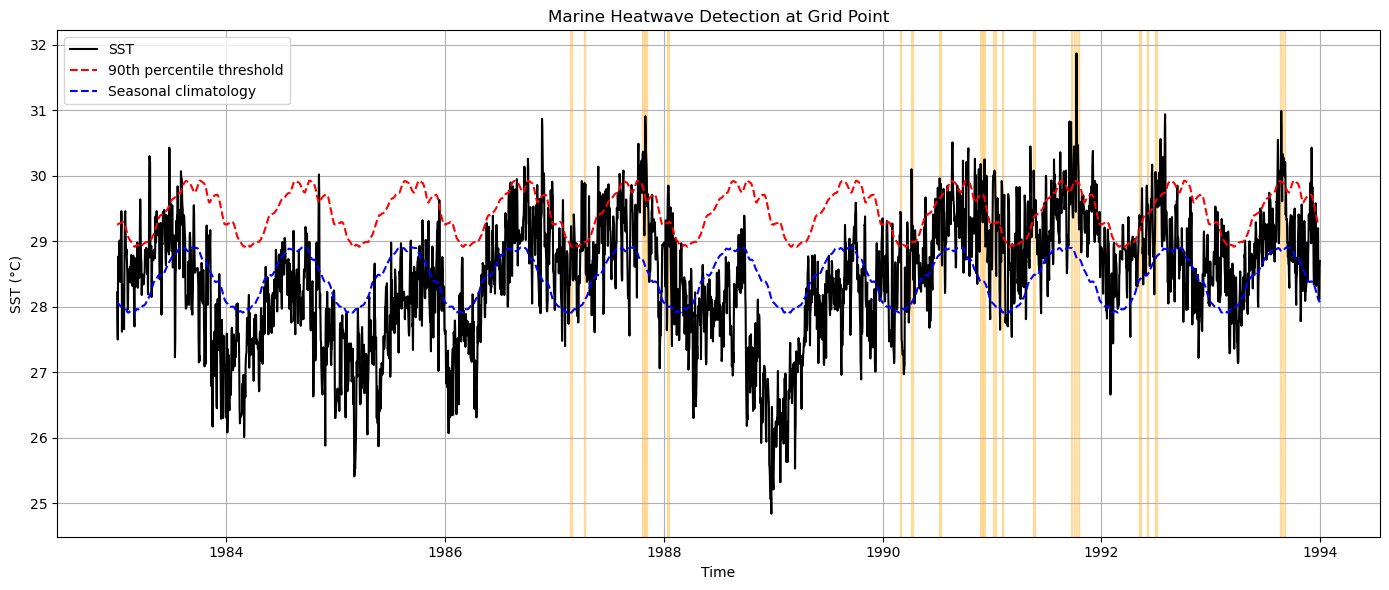

CPU times: user 187 ms, sys: 4.04 ms, total: 191 ms
Wall time: 184 ms


In [27]:
%%time
# Convert ordinal dates to datetime
times_dt = [datetime.date.fromordinal(int(d)) for d in time_ord]
start_dates = [datetime.date.fromordinal(int(d)) for d in mhw_events['time_start']]
end_dates = [datetime.date.fromordinal(int(d)) for d in mhw_events['time_end']]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(times_dt, sst_ts, label='SST', color='black')
plt.plot(times_dt, mhw_thresholds['thresh'], label='90th percentile threshold', color='red', linestyle='--')
plt.plot(times_dt, mhw_thresholds['seas'], label='Seasonal climatology', color='blue', linestyle='--')

# Highlight MHW periods
for start, end in zip(start_dates, end_dates):
    plt.axvspan(start, end, color='orange', alpha=0.3)

plt.title("Marine Heatwave Detection at Grid Point")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()